In [10]:
import matplotlib.pyplot as plt
import torch.nn as nn
from model import SingleViewto3D
import sys
sys.path.append('..')
sys.path.append('../assignment1')

In [11]:
def visualize_feature_maps(model, input_feature):
    # Store intermediate activations
    activations = {}
    
    def hook_fn(name):
        def hook(module, input, output):
            activations[name] = output.detach() # NOTE: record the output of the layer each time it is called
        return hook
    
    # Register hooks for each deconv layer
    hooks = []
    for name, layer in model.named_modules():
        if isinstance(layer, nn.ConvTranspose3d):
            hooks.append(layer.register_forward_hook(hook_fn(name)))
    
    # Forward pass
    _ = model(input_feature)
    
    # Visualize intermediate 3D feature maps
    for name, activation in activations.items():
        # Take first sample and average across channels
        feat_map = activation[0].mean(dim=0).detach().cpu().numpy()
        
        # Create 3D visualization using matplotlib
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)
        
        # Show different cross-sections
        ax1.imshow(feat_map[feat_map.shape[0]//2, :, :])
        ax2.imshow(feat_map[:, feat_map.shape[1]//2, :])
        ax3.imshow(feat_map[:, :, feat_map.shape[2]//2])
        
        plt.suptitle(f'Feature Maps at {name}')
        plt.show()

In [12]:
import argparse
def get_args_parser():
    parser = argparse.ArgumentParser('Singleto3D', add_help=False)
    parser.add_argument('--arch', default='resnet18', type=str)
    parser.add_argument('--vis_freq', default=1000, type=int)
    parser.add_argument('--batch_size', default=1, type=int)
    parser.add_argument('--num_workers', default=0, type=int)
    parser.add_argument('--type', default='vox', choices=['vox', 'point', 'mesh'], type=str)
    parser.add_argument('--n_points', default=1000, type=int)
    parser.add_argument('--w_chamfer', default=1.0, type=float)
    parser.add_argument('--w_smooth', default=0.1, type=float)  
    parser.add_argument('--load_checkpoint', action='store_true')  
    parser.add_argument('--device', default='cuda', type=str) 
    parser.add_argument('--load_feat', action='store_true') 
    return parser

In [13]:
import sys, torch

sys.argv = ['eval_model.py', '--type', 'vox']
parser = argparse.ArgumentParser('Singleto3D', parents=[get_args_parser()])
args = parser.parse_args()
model = SingleViewto3D(args)
# print(args.device): # NOTE: cuda
print(args.type)
checkpoint = torch.load(f'../checkpoint_vox_1000_1000.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(args.device)

vox


In [14]:
from r2n2_custom import R2N2
from  pytorch3d.datasets.r2n2.utils import collate_batched_R2N2
import dataset_location

r2n2_dataset = R2N2("test", dataset_location.SHAPENET_PATH, dataset_location.R2N2_PATH, dataset_location.SPLITS_PATH, return_voxels=True, return_feats=args.load_feat)

loader = torch.utils.data.DataLoader(
    r2n2_dataset,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    collate_fn=collate_batched_R2N2,
    pin_memory=True,
    drop_last=True)
eval_loader = iter(loader)
# print(args.batch_size) # NOTE: 1

 category   #instances
----------  ------------
  chair     6780
  total     6780


torch.Size([1, 137, 137, 3])
1


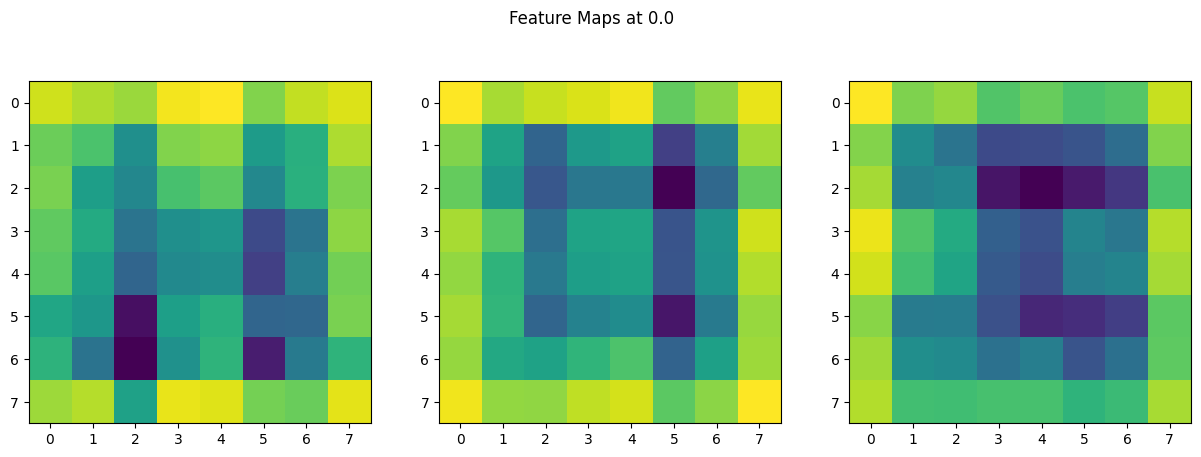

1


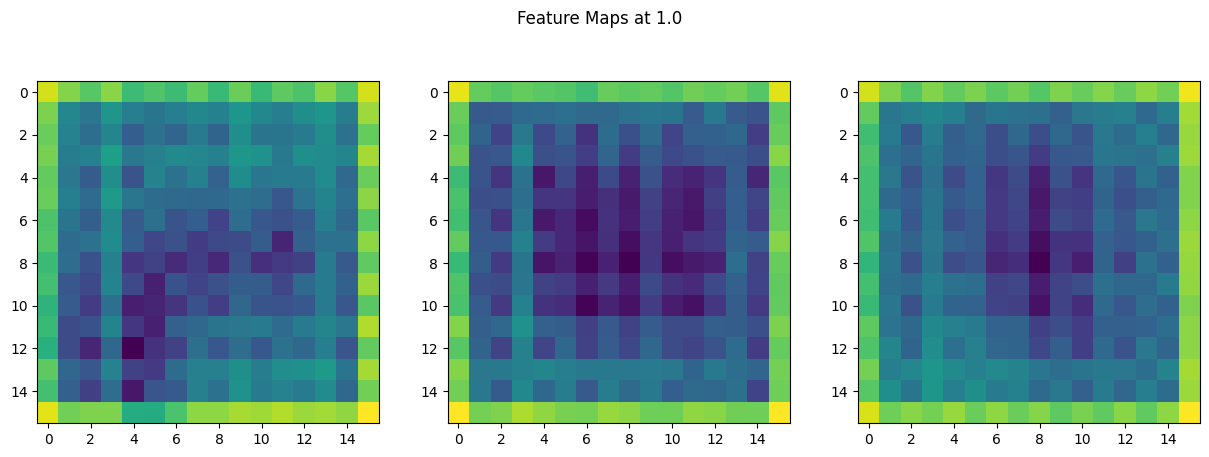

1


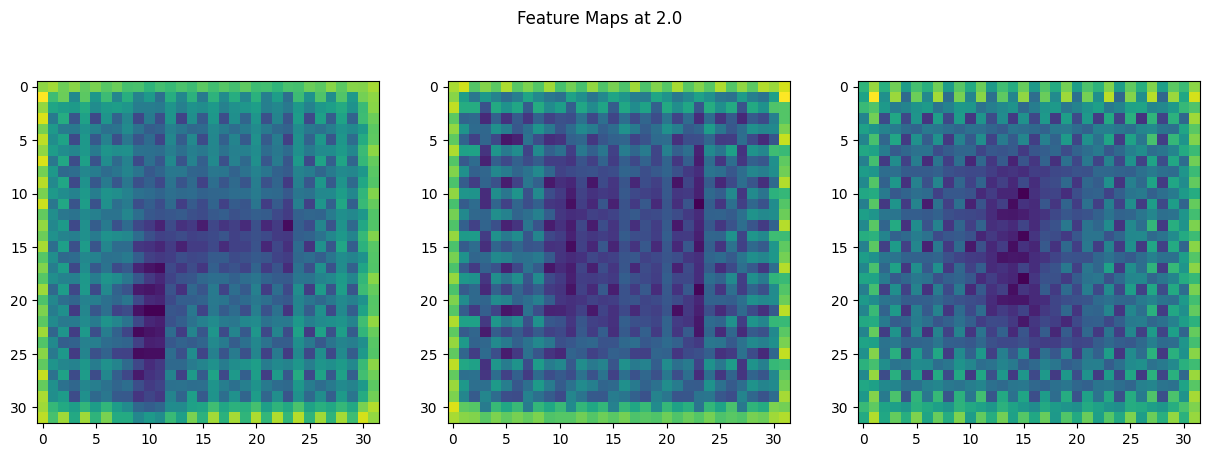

In [15]:
from eval_model import preprocess

feed_dict = next(eval_loader)
images_gt, mesh_gt = preprocess(feed_dict, args)
print(images_gt.shape)
images_normalize = model.normalize(images_gt.permute(0,3,1,2))
encoded_feat = model.encoder(images_normalize).squeeze(-1).squeeze(-1) # b x 512
projected_feat = model.voxel_projection(encoded_feat).reshape(-1, 512, 4, 4, 4) # b x 32 x 32 x 32

visualize_feature_maps(model.decoder, projected_feat)